In [5]:
### Data Manipulation
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import itertools

### Text Manipulation
import nltk # natural language processing toolkit
from nltk.corpus import stopwords
from nltk.stem.porter import *

### Feature Manipulation Functions
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS

### Word2Vec
import word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

### Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

### Other
import numpy as np 
import re
import nltk.data
import warnings
from matplotlib import pyplot as plt   

First we load the data and leave only the tweet text and the class

In [2]:
data = pd.read_csv("disaster-tweets.csv", encoding='latin1')
data = data.drop(["_unit_id","_golden","_unit_state","_trusted_judgments","_last_judgment_at","choose_one_gold","choose_one:confidence","keyword","location","tweetid","userid"], axis=1) 
data.columns = ['target','text']
data = data[data["target"]!="Can't Decide"]

Further we load the tweeter word vectors and save them

In [3]:
### Glove vector read

def read_data(file_name):
    with open(file_name,'r',encoding="utf8") as f:
        word_vocab = set() # not using list to avoid duplicate entry
        word2vector = {}
        for line in f:
            line_ = line.strip() #Remove white space
            words_Vec = line_.split()
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

vocab, w2v = read_data("glove.twitter.27B.100d.txt")

Total Words in DataSet: 1193514


In [4]:
vocab_2, w2v_2 = read_data("glove.twitter.27B.200d.txt")
vocab_3, w2v_3 = read_data('glove.twitter.27B.50d.txt')
vocab_4, w2v_4 = read_data('glove.twitter.27B.25d.txt')

Total Words in DataSet: 1193514
Total Words in DataSet: 1193514
Total Words in DataSet: 1193514


# Preprocessing

Some abbreviations that might make the life more difficult to classifiers

In [74]:
#Source: https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [75]:
def preprocess_text(tweet):
    # 1. Remove HTML
    review_text = BeautifulSoup(tweet).get_text()
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', review_text)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", parsed_text) 
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    # 4. In Python, searching a set is much faster than searching
    stops = set(stopwords.words("english"))  
    stops.add('https')
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]  
    # 6. Change abbreviations to original words
    tokens = [convert_abbrev(word) for word in meaningful_words]
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( tokens ))  

In [76]:
num_tweets = data["text"].size
clean_tweets = []
for i in range(0, num_tweets):                                                             
    clean_tweets.append(preprocess_text(data.iloc[i]["text"]))

happened terrible car crash
deeds reason earthquake may allah forgive us
heard earthquake different cities stay safe everyone
forest fire spot pond geese fleeing across street cannot save
forest fire near la ronge sask canada
residents asked shelter place notified officers evacuation shelter place orders expected
people receive wildfires evacuation orders california
got sent photo ruby alaska smoke wildfires pours school
rockyfire update california hwy closed directions due lake county fire cafire wildfires
apocalypse lighting spokane wildfires
flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
typhoon soudelor kills china taiwan
shaking earthquake
top hill see fire woods
emergency evacuation happening building across street
afraid tornado coming area
three people died heat wave far
haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding
raining flooding florida tampabay tampa days lost count
flood bago myanmar arr

twelve feared killed pakistani air ambulance helicopter crash
two air ambulances scene serious crash two cars lorry emsne
twelve feared killed pakistani air ambulance helicopter crash reuters yugvani
twelve feared killed pakistani air ambulance helicopter crash
leading emergency services boss welcomes new ambulance charity
anyone travelling aberystwyth shrewsbury right incident services halt outside shrews ambulance scene
twelve feared killed pakistani air ambulance helicopter crash
ambulance sprinter automatic frontline vehicle choice lez compliant ebay
dying send ambulance
new nanotech device able target destroy blood clots
ambulance sprinter automatic frontline vehicle choice lez compliant ebay
hella crazy fights ambulance couple mosh pits
ambulance even parked well like nearly top someone car laughing
get run ambulance lucky justsaying randomthought
news twelve feared killed pakistani air ambulance helicopter crash today i learned dna
twelve feared killed pakistani air ambulance he

another hour august prime minister red rover zombie apocalypse internetradio collegeradi
one major reasons live big city rr miss meals ever comes pass cue apocalypse script
feel like pull one stages apocalypse
kinda hot played radio today next disease apocalypse started everyone careful
askconnor zombie apocalypse item right weapon either screwed gonna live
apocalypse laughing out loud gf
know question interpretation sign apocalypse called
apocalypse
julie r apocalypse version romeo juliet warmbodies
apocalypse upon us
excited apocalypse really dig x men franchise going like event theme lot
retweet fittscott minecraft night lucky block mod bob apocalypse wither mod showcase popularmmos vi
sounds like terrible time right
apocalypse artists go fukushima exclusion zone nuclear ura
begins day one snow apocalypse
retweet mother mary short reading apocalypse spirit angel took top enormous high mountain
candylit imagine sarumi zombie apocalypse fighting back back heart heart conversations
ret

suspected serial arsonist arrested norcal
guess you say shit thinking
surveillance video captures man removing american flag long beach home ktla
arsonist sets new york city vegetarian restaurant fire police newyork
liked video town salem win arsonist
whats cracking cuz
smoke good fuck eat drink drive nice car wear green mink
serial arsonist gets bail jail release
kill got court day earl
laugh my ass off real live go
owner chicago area gay bar admits arson scheme frank elliott pleaded guilty hiring arsonist
trusting iran stop terrorism like inviting arsonist join fire brigade telegraph
big top burning true story arsonist missing girl
arson suspect linked fires caught northern california
stay vigilent civil liberties constant attack nativehuman myreligion
delhi government provide free treatment acid attack victims private hospitals aapatwork
going panic attack
credit inspiring rediscover fantabulous tbt
end innovation catch reduce attack surface industryinsights mcgsecure
nashville thea

avalanche men lunatics livingontheedge
chevrolet avalanche lt lt used l v v automatic wd pickup truck premium b
snowflake avalanche ever feels responsible
star wars power jedi collection battle droid hasbro full read ebay
civil war general battle bull run hero colonel nd new hampshire letter signed
dragon ball z battle gods rotten tomatoes via
added video playlist world tanks battle assistant mod bat chat arti kaboom
ya boy clip vs kus full battle
indeed fully aware battle support fight
baaaack petersen bowhunting battle bows make sure head cast vote
tb throwback want battle war
kelby tomlinson mild mannered nd baseman great metropolitan team fights never ending battle hits rbi sfgiants way
black eye space battle occurred star involving fleets totaling ships destroyed
really happened taken king story trailer space battle ripped hole saturn
battle animations fucking much
see happens battle block finally
du gon get rap battle
thing battle internal vs external motivation
environment lone 

alrighty hit blaze
blaze jays fuck dutch slave trade
yeah gimme dat creamy white stuff
hair poverty moment need get fade weekend gets
property losses california wildfire nearly double week old blaze rages
breaking firefighters battling blaze east cary condo building
niggas love hating
like babes ball fun lan
reaction determines
port coquitlam fire crews say electric towel warmer started four alarm blaze last week destroyed several businesses
liked video minecraft skywars blaze que usa hack e flechadas sinistras
dems blaze covered months ago chicago police detained thousands black americans interrogation facility
yo got bars even rapper
liked video blaze atgames handheld mega drives ashens
ugh blaze put calories pizzas ok cool thisispublichealth
pic blaze fort kids look like jackass stuffin face like
looks like year writing computers ahead
letting know
mad name blaze
yeah know blaze blue dont twitter laughing out loud drew weeks ago
socialmedia news new facebook page features seek help 

freyas video blew everywhere
easy way look good ray rice fiasco blew
laugh my ass off light skin guy blew twitter talking ugly kid
watched honey blew economy recommend conservative shoppe horrors harperanetflixshow elxn stopharper
balloon thing rude would popped balloon whoever blew face
anyone else see fireball falling earth look like plane blew
ye thing big sean still blew
zayn blew twitter
yeah true got exposed probably went mlg blew
bitch done blew shit
reason player ego cause mw cod champs esports blew player strictly look orgs
damn clue tried see many clicks could get blew played
great pair like couple graywardens fighting blight
theres actually theory magisters arent reason blight dwarves ones
thda kicks anti blight loan effort memphis
cycling fan feel sorry world athletics doping blight exacerbated monetary reward lot soul searching required
land bank targets first latrobe building th property acquisition fight blight
blight
lots talk susceptible ny shoot blight without trama w

precious lunch bloody hell brain issit
swear eyes bloody red bitch feel amazing
eh hello cover bloody thighs bloody cleav eh hello since expose cleavage
anyway running mouth bloody game pree sure bigger baseball calm hell
bloody nurses waking eventually fall asleep laughing out loud hospital
mega bloody marvellous
bloody mary sink beet juice
monty python date bloody far wants go
meet bloody rs
friday supposed happy day bloody friday hah zzzz
bloody hope said folding arms sitting back chair
wait tell college friend reafs bloody mary drama cd
deal right oh my god remembers bloody mary
nightmare elm street getting remade via
came kill indians fun video smirking remorseless pakistani killer shows boasting
bloody hell teen wolf hayden liam cute think stiles jeep dead huh pleeease loved
watched episode e bloody monday bloodymonday tvshowtime
marlon williams elvis presley marlon williams steel panther shuffle mode like bloody legend
black friday turns bloody would rather shopping mystery
luck

womens flower printed shoulder handbags cross body metal chain satchel bags blue
womens cross body messengers bags clutch small shoulders zippers bags white
bring body bags though
us institute peace chairman wants russian body bags
update va firefighter administrative leave facebook post calls people put officers body bags
send poor middle class children war come body bags typical gop
body bags
nine giant body sized garbage bags later going start throwing things away moving k expertwhiner
love body shop bags cutekitten catsofinstagram summerinsweden katt katterp instagram dumle dagens
womens tote faux leather handbags shoulder cross body top handle bags rose
womens satchel lattice chain studded cross body multi colour shoulder bags blue
lab today ready body bags
bitches takin pics bags bigger whole body
womens buckle casual stylish shoulder handbags pockets cross body bags green
fairfax co investigating firefighter khalil abdul rasheed facebook post saying police shld put body bags
ira

happened asia japan marks th anniversary hiroshima atomic bombing
like survive atomic bombing hiroshima
setting success bells toll hiroshima japan marks years since atomic bombing news smallbusiness entrepreneur
australia news japan marks th anniversary hiroshima atomic bombing read
yea bombing pearlharbor good idea
cryptic words guided pilots hiroshima bombing mission
th anniversary hiroshima atomic bombing marked
japan marks th anniversary hiroshima atomic bombing
japan marks th anniversary hiroshima atomic bombing
japan marks th anniversary hiroshima atomic bombing
th anniversary hiroshima bombing
japan marks th anniversary hiroshima atomic bombing
push left talk ecology human rts democracy war afghetc left humanitarian bombing
hiroshima bombing justified majority americans even today hindustan times
japan marks th anniversary atomic bombing hiroshima
japan marks th anniversary hiroshima atomic bombing associated press via nyt
bells toll hiroshima japan marks years since atomic bomb

fire burning pendleton burned acres smoke reported drifting temecula
probably stay away hot glue guns burned one finger pretty bad
progress making middle ages would burned content burning books sigmund freud
family heartbroken mobile home nellis cheyenne burned fire kids ready go back school
uh huh burned know fire hurts robbie ross throw home run derby star game redsox
burned popcorn
burned fingers
burned stake
let tell brandace brought today ntc heat survived burned
others get burned
taking shower someone flushes toilet second gtfo get burned
always look silver lining barn burned ground see moon mizuta
sure burned calories eating giant bowl mac cheese totally earned calorie klondike bar
alton brown livestream burned butter touched hot plate soon made nut joke
look sports riots google see couches burned fr gotta go
spent minutes walking runkeeper calories burned loseit
sure take away fire fighting king stevie crusty photo op
last cities everyone burned death terrorism grandest scales


never understood guys wanted run burning buildings chase murderers fire
dudes thoroughly express stupid black people r burning buildings response brutality never mention mistreated
picture buildings burning ground basement streetlight drinking problem hole sky
pledge allegiance p p e burning buildings epic city
protests riots burning buildings come see crap happening
insane bush fires california safe
would please explain going volcanoes bush fires spouting co air
middle winter sydney snow bush fires degree days last week keeps toes sure
attack pages attack women health attack women health attack america health
ted cruz fires back jeb bush lose republicans like jeb mitt video
omfg bush fires tiny island freaking house gonna burn
soaring temperature southern us states causing bush fires pity allow rain scotland tweetlikekez
know hot bush fires right near villa
slash burn blamed bush fires western st thomas
drought fuels bush fires jamaica
ted cruz fires back jeb bush lose republicans lik

migrating iphoto photo catastrophe wasted days trying get work hrsto get complete
cultivating joy face catastrophe suffering pjnet tcot ccot
borrowers concerned possible interest rate rise could catastrophe
coming catastrophe destruction puppet republic half naemolgo continue firmly support yiraneuni
failure misfortunebut regret catastrophe
catastrophe man opens school w another athlete teacher principle fulfilling inside clerical duties
iphone twist ultimate preparedness library prepare catastrophe ov
envision catastrophe would prevent woman placing child adoption
good grounds believe political military catastrophe crime planned committed individuals
stylist silent says cool show amazon prime called catastrophe
fox news biggest media catastrophe american history people love living lie
boy mix ultimate preparedness library prepare catastrophe
god bless catastrophe
slightly diff catastrophe barry running solo generally thing
twist sony ultimate preparedness library prepare catastrophe
u

gulfport energy realizations fall cliff
jumps cliff drinking tea british people fall cliffs
lower striked would gone even otm could really fall cliff
sounds like really bad idea like yoenis feel like production could fall huge cliff
bride groom mountain cliff edge ha ha kidding ever ha ha
esn cilla black died stroke fall spain sir cliff revealed due visit spain next
looks tasty problem cliff might fall sea due coastal erosion would crumbly
nowplaying cliff richard could easily fall love shadows internet nieuws radio
runaway minion causes traffic collapse dublin
interview collapse materialism best talkradio listen live
time collapse cool video technique
would paramedic really leave someone inside building collapse blow
see option buy full collapse vinyl tee bundle waiting
warne ponting shocked australian collapse yahoo cricket india
greece tax revenues collapse debt crisis continues
watch terrifying moment two giant cranes collapse onto homes row homes destroyed seconds
barbaric saudies

funfact facts stars collide
worlds collide american family takes britain isle man new tlc show suddenly royal via
houston new york city collide gemma bowe
setlist past sunday powerful song favorite
thedoolinggroup injured school buses collide breaking school bus slams school bus bordento
transgender sam takes runaway lizzie two different worlds collide explore unjust boundaries trust sam uel books
even words slip souls coincide finer subatomic spells collide
devia ler collide wattys wattpad teenfiction
social media marketing ethics rules collide recorder
trump bill clinton collide best conspiracy story ever via trump democratic plant laugh my ass off lastword
pierce veil rubber bracelet wristband collide sky full read ebay
days collide get signed
secrets world collide leave past behind long go without
high fashion food collide
either ride us collide us simple niggas
cyclist collided runner roanoke greenway wins civil verdict via
fav worlds collided thanks found podcast ihave episodesof

news bin laden family plane crashed avoiding microlight landing far runway three member
thief broke front window hicksville store stole cell phones fled crashed
aqgco mhtw fnet pakistan says army helicopter crashed country restive northwest fox news
army sources say persons board including team doctors die helicopter crashed near mansehra weather seems cause crash
got ticket car got crashed man life great
pak army helicopter crashed mansehra pray departed souls
skype crashed you host
already phone updated somehow phone crashed restore letting restore
second faster overtook twice crashed tru luv
nearly crashed car typing paul rudd attacked flying ants notes phone
honestly nightmarish god driving new places always stressful shit hate much ugh almost crashed times
crashed car parked car day modestmouseremix truestory
website malfunctioning php scripts working database crashed need unique script php pro rescue
f mhtw fnet pakistan says army helicopter crashed country restive northwest fox 

cyclone passion overblown
majesty emperor salman khan unstoppable cyclone entertainment humanity bajrangi bhaijaan creating history everywhere crosed cr
raleigh cyclone gear mountain bike sportinggoods
mercury cyclone gt quarter panel rear trim moulding cobra jet cj
tropical cyclone info soudelor hpa maximum wind speed maximum wind gust speed
may ask cyclone sama read jailed fate rindou
drugs alcohol jackson vroman house
retweet severe weather bulletin typhoon soudelor tropical cyclone warning issued prime minister
blending old new vanuatu prepare future emergencies
red tropical cyclone alert soudelor china northern mariana islands aug coordinated universal time
localeventcountdown curtain opens black cyclone shelby tickets info rstoday
wfp wfp delivers food bangladesh flood victims tropical cyclone komen dhaka united na
may rodder super stock keeling mustang barracuda riviera cyclone
rohingya houses kyee nockthie hamlet taungbazar region buthidaung severely damaged cyclone
cyclone dou

askcharley emmerdale emotional ross dead
man found dead demi moore swimming pool
boyfriend ex feelings dont talk follow dead exist niggah
val dead im suing
everyone know chris prater struck train morning pronounced dead scene prayers family
real nah mother dead wrong
dead
way ross dead emmerdale
wyrmwood road dead fucking awesome awesome ending awesome one
believe ross dead emmerdale summerfate
incredible character heart broken actually dead ripross miss
call text niggas bff boyfriend love boys death niggas hold attention like
hate talking otp grandma mean love death talk damn much ssshhheeesshh
death forever rep jets
vibrator shaped vape done busted
black death black death whoo
liked video camp bunk disney channel
death threats nigga life well gon see
adult dies plague colorado
xbox pro console red ring death full read ebay
going back gainesville death
year later ferguson sees change asks real
papiichampoo enjoy obama era civility prez says gop supports iranian death
feel like death
l

debris confirmed mh relatives hope discovery crash site via video
plane debris missing mh
investigators plane debris conclusively mh gadgets tech
mh aircraft debris found la reunion missing malaysia airlines abc onlin g malaysia news
top story mh reunion debris missing plane british broadcasting corporation news see
per malaysia prime minister piece debris conclusively part wing mh right
interesting mh aircraft debris found la reunion missing malaysia airlines abc please retweet
interesting mh aircraft debris found la reunion missing malaysia airlines abc please retweet
aircraft debris confirmed mh nation star online
ah awash abstract dustpig tweets explains deluge
bet mother nature might plans send deluge way
feed seems deluge twice week fantastic
rmt playing jackson browne deluge listeners requests
welcome organizing twitter find important stuff amongst deluge by the way loving music signed ep
niagara falls package deals deluge tours yyeso
apologise sincerely inevitable deluge gbbo t

starting gofundme page new set rims since demolished mine last night helpabrotherout
really demolished
demolished one favorite restaurants put chik fil hope one goes hope tanks
demolished snowball
finally demolished spring property sat vacant since saddlebrooke
six palestinians kidnapped west bank hebron home demolished international middle east media center
uttarakhand journalist house demolished exposed corruption oneindia
demolished
underconstruction demolished melbourne residential commercial builder luxuryhomes townhouses
palestinian homes demolished israel since w israeli home demolished
take china get demolished sent back fucking stone age
home suites offices coming salvi bistro site former salvi bistro soon demolished make
bbsnews latest palestine israel six palestinians kidnapped west bank hebron home demolished
trump get absolutely demolished general election
finally demolished spring property sat vacant since saddlebrooke
totally demolished genisys beautiful film almost peop

teamfollowback madhya pradesh train derailment village youth saved many lives followback
photos green line derailment
modiministry madhya pradesh train derailment village youth saved many lives
still box alarm train derailment st calumet struck orders chicagoscanner
consent order cleanup underway csx derailment site knoxville news sentinel
madhya pradesh train derailment village youth saved many lives group villagers saved passengers lives two train
cta green line passengers evacuated due derailment however service garfield cottage grove
madhya pradesh train derailment village youth saved many lives
madhya pradesh train derailment village youth saved many lives group villagers saved passengers lives two train
mp train derailment village youth saved many lives indiatv
madhya pradesh train derailment village youth saved many lives group villagers saved passengers lives two train
know cow incident yr fault line could caused derailment
madhya pradesh train derailment village youth saved ma

ginga thinks defeat l drago destroy
black ops search destroy gameplay hunted snd competitive multiplayer via
gop want destroy america obama dilutional institutionalize sued slander
shantae get smash destroy wii you shantaeforsmash shantae shantaehalfgeniehero nintendo
ng x mhtw fnet watch michael jordan absolutely destroy meme baiting camper foxsportscom
made anthonys bed considering destroy everytime fall asleep shake my head
together destroy emperor rule galaxy father son
dem flatliners destroy creativity balance longevity truth stand lucifer flames destruction
watch super strong magnets destroy everyday objects
money grubbing kikes need get cluei money still destroy telekinesis watch
jake swear god one god damn piece algae ponds going destroy little fish momtherbot
yiayplan use awesome collection amiibos destroy path
get free bets register boylesports casino luck destroy
people destroy unless let
say either us displeased you move five spots jamaica congrats reggaeboyz
destroy you
so

young heavyweight rapping detonate leader lemon better get straight
apollo brown detonate f p
apollo brown detonate f p orapinforma
listen apollo brown detonate feat p mello music group np soundcloud
nuke please target hilversum please detonate meters surface
yo you sexy
terrorism war army intel agents counter moves detonate bombs
apollo brown detonate f p hhbu
another stand user detonate killer queen
apollo brown detonate feat p mello music group via soundcloud
detonate feat p apollo brown
detonate featuring p
message self detonate
detonate feat p grandeur apollo brown
signed detonate nottingham autumn launch party register
everyone hoped would join isis get ventilated marines trying detonate bandolier hot dogs fort dix
another stand user detonate killer queen
apollo brown detonate featuring p fiya
succeed two times either bomb detonate shots missed
press play new single p detonate
apollo brown detonate featuring p
another stand user detonate killer queen
hiphop news indie apollo brow

reade see politicians leading us disaster greedyrich
beautiful disaster jon mclaughlin good song
paladins going disaster
w giving much nana france reminds america right war iraq restlessness leading disaster
strengthening partnerships afterhaiyan haiyan yolandaph philippines livelihood disasterrecovery disaster
beautiful disaster
microsoft nokia acquisition even bigger disaster ever imagined
first staining attempt disaster
overpopulation r women incapable keeping legs together save world endless brats want run disaster
harper gets sassed albertans calling ndp government disaster via harperblamesalbertans
cw dealing disaster
want go back vegas feel like would disaster laughing out loud much money would need brought
blue bell may close return listeria disaster hot theneeds recipes
jeff locke train wreck f disaster fortunately pirates acquired top quality starter j oh wait blowltan
metepec mexico night disaster e oficial nitclub sica sica
disaster averted police kill gunman hoax device ci

drown clementines
genuinely like someone reallyyy like hold back else drown affection attention
drown bring horizon information resources centre utp
fuck around drown
going go drown sorrows sad music be right back
absolute drown wagyu steak heaping piles moist smuckers grape jam
drown make heart beat like rain
legit drown
yeah definitely gonna go drown pool bc damn hot inside
fall drown think pass
send drown like way you think allthekidneybeansandsorbet misha yes
tears drowned terrible taste also nataly gave steak cheese thing cheer
clev clev indeed know happened ben clev drowned clev father
what the fuck mom drowned child
hundreds feared drowned migrant boat capsizes libya
sadly could save humanity ursula drowned drool protoshoggoth least sort died loved
drowned kiddie pool lost ploppy
jacksonville family bands together memorial planned toddler florida
future america gamergate
hey stephen remember time drowned yellows read
hundreds feared drowned migrant boat capsizes libya hundreds m

new mad max screenshots show lovely dust storm combat magnum opus
dust storm pheonix
nasa modis image dust storm morocco straits gibraltar duststorm
earthquake sismo km e interlaken california time coordinated universal time
earthquake occurred near mount st helens area washington coordinated universal time earthquake
contruction upgrading ferries earthquake standards vashon mukilteo q fox earthquakenews
novices renison mine sees seismic event small earthquake tasmania renison tin project created tem
put right person block shelli sense entitlement ridiculous bb
earthquake sicily italy iphone users download earthquake application information
usgs eq km twentynine palms california time coordinated universal time earthquake
posted new song earthquake
aftershocks big initial earthquake
sismo ml near coast western turkey magnitude ml region near coast western turkey cs
usgs eq km ssw anza california time coordinated universal time earthquake
earthquake occurred km e anchorage alaska coordin

setting emergency fund easy steps never know surprise expense pop work
eyes nation broader conservation community alaska reinstate emergency buffer protectdenaliwolves
gonna call tomorrow aul emergency dental appointment excuse like whole tooth falling incident last year
loans settlement day emergency money advances treasure house self outbreed take home akx
job case emergency
peacetime times national emergency
lean thinking quicker police emergency response time
hey mom said tell dad call as soon as possible emergency
leaving back sf friday packed one single thing emergency
former heroin addict shares story city leaders sound alarm city officials said emergency teams responded
busty blonde teen natalia starr fucks security guard set view download video
came across fire video mine enjoy fire firemen firetruck emergency rescue summertime sirens
emergency hop kit just kidding
enjoyed show today great fun emergency non evacuation interesting great run
denali wolf population declined reins

fire alarm going zehrs keep working minutes decide evacuate everyone
california monster fire contained told evacuate
guy next walks tiny office room fishiest smelling lunch ever evacuate
cannon ball ocean japan would evacuate
firefigthers evacuate northampton township house fire
rather ass fire least know whatever eat evacuate heartburn sticks around
okay need evacuate house write poem
fire crews evacuate passengers gold coast tram trapped powerlines fell across carriage tennews prime minister
cascada evacuate dancefloor official video via
disregard snap story angry white girl riot happening speak evacuate
fwd literally jumped bed put beach clothes ran door like evacuate apocalypse
salha harry styles you know ur p eople hurry evacuate hell shahada pick class sick
isis deploying troops battle grounds since deal turkey evacuate buffer zone areas hence moving fronts assad
pls alllll nittys evacuate stockwell
cancel fucking show evacuate metlife
condemnation clearly replacing latest respon

fact checking machine must exploded today following irandeal speech
im dead two loves photo heart exploded million pieces
dress memes officially exploded internet
final medinah update shot front exploded back imkeepingmydayjob pic famous
well chaning ipad screen fucking exploded glass went place looks like job going need new one
aphid population northiowa exploded last days fromthefield
dress memes officially exploded internet
little heart exploded otrametlife mtvhottest one direction
junko years old atomic bomb exploded hiroshima august
similar thing john carpenters thing one girl threw dogs exploded
saw man whose mind exploded drako zarharzar day
bleach skin touching thong shudder boudoir outfits eyeballs bleeding brain exploded
holy hell bathroom car smells like exploded
read break hours twitter noticed though nothing worry bc twitter exploded bc
exploded brought beginning universe matches mentioned versethe heaven earth thus universe
exploded brought beginning universe matches ment

russian food crematoria provoke outrage amid crisis famine memories moscow reuters russian government
guys bitches famine
food crematoria provoke outrage amid crisis famine memories
russia food crematoria provoke outrage country w soaring poverty soviet famine memory
hunger hits function probably last long famine zones thank god
russian food crematoria provoke outrage amid crisis famine memories
according gallup poll money likely suffer time famine ari
people like unu feast today famine tomorrow
top turn darkness king redeem queen serene famine wolf
russian food crematoria provoke outrage amid crisis famine memories reuters via nyt ukraine
russian food crematoria provoke outrage amid crisis famine memories
example low food prices cause farmers go broke famine next year means simple capitalism failed feed people
memorial millions perished holodomor erected you capital
exporting food wont solve problem africans end famine n poverty solving control tribal wars
food crematoria provoke outr

hibernating pbx irrespective pitch fatality careerism pan crbzfz
fatality
dying lyme disease case fatality rate nearly
you fatality like corpse still jittering
fatality
fatality
wow fatality big rig hit motorcyclist blood everywhere wow sick
nah hit homie wit fatality son wit babality cold cold fuck lmfaoooo
kosciusko police investigating pedestrian fatality hit train thursday
fatality
yes life fatality rate
many baskets charming fatality get mystery paranormal
making bad boys must see
need team need one
afghan soldier kills us general america highest ranking fatality since vietnam
usually never happens
fatality
mortalkombat mortalkombatx mkx fanart fatality follow gaming pictures youtube
cat fatality utica ny pleasant holland ave black cat white paws average size grass next north side road
come south like ya name asher big h come fatality bars minor lotm battle
let writing suffer fatality learn seek destroy bad writing weekly live write thrive
fatality
fatality
jax mk stage fatality u

njturnpike njturnpike reopens hours truck fire
lukebox something first responders military true hero besides music
grateful first responders others acted swiftly save countless lives today
praying god healing safety first responders
must educate first responders adapt emergencies involving autistic individuals
central indiana first responders providing feedback third final firstnet focus group today
join charity k run event start sun sept castle donington community first responders
loved way book written include many vantage points first responders kindle
first responders would never sent wrong address w smarttek global positioning system based panic button mpers safety
news saint louis university lowers tuition first responders
help says denver firefighter working curb first responder suicide
community first responders cfr radio ham tony hancock
first responders tell lucky someone riding today
cool teens becoming like call digital first responders friends need little help support
good

mum literally picked new car today flattened battery already trying sort bluetooth muppet
give lunch money ner flattened falling quarter
see flattened cyberman watch way much doctor
satisfaction knowing flattened someone logic reasoned argument
notley flattened harper heartland harper imported tens thousands that feeling when slaves cost albertans jobs
flattened frog
imagine getting flattened kurt zouma
fallacy steam roller object whether flattened robertcalifornia thereisonlysex
photo beach earrings beach jewelry vacation earrings keep calm beach earrings made flattened
mix new flat double sided linerless bottle caps choose mix flattened full
flat footballs like flattened spartans crushing back day hail
ever seen far dreamy look came face ears flattened started walk slowly toward
mix new flat double sided linerless bottle caps choose mix flattened full
fizzy sitting regular flood seats one knows
spot flood combo inch w curved cree led work light bar x offroad fog lamp full
jkl cancels

little forest fire wardens
fire pisgah national forest grows acres
ashenforest floorburnt manzanita timber johnson fire along ridge forest road routecomplex
grass fire near forest grove contained sparked rock struck tractor liveonk
runs setting forest fire bites shit neck
sets forest fire
liked video j cole fire squad forest hills drive
view smoke column rising south end blake fire along forest road routecomplex
damn dry desert forest fire damn
starts forest fire cannot put
winston salem fire pisgah national forest grows acres
fire pisgah national forest grows acres
grill school function one grills going pretty much either forest fire inbetween made work
crews responding small brush fire burning tahoe forest news krnv reno nv
p watch forest fire smoke lifted nuff f make run pet store hwy n b home p
forest fires socal fire watch realhiphop
oh my god news chopper acre mostly contained fire outside forest grove slownewsday
you forest service firefighter david ruhl died frog fire modoc nat

calgary transit reviewing policy leaving hundreds commuters stranded hail
passengers abandoned lrt station tuesday hailstorm yyc yycstorm abstorm
quality metrics penalties may harm patient care pcps say primary care physicians generally hold positive vi
think lot celebrities treat people could harm
sticks stones may break bones words never harm
g anyone tries harm cupcake fucking hunt end earth harrybecareful
vanderbilt first harm
love picked playing worth fifth harm kid ink listen vote
imagine doctor treating ebola patient without ever placing harm way
right annoyed actually hung see mean harm
burned self harm way dumbass allowed around fire way
concur longer spend child harm mmk
mental health real self harm real depression real feeling alone fit one day could
people keep tagging self harm fucking
harsh penalties legal firearm owners straw purchase firearm felon gang members intend cause harm
love picked playing worth fifth harm kid ink listen vote
pray harm members isis pray experien

never really seen olive leaf extract help rash good luck humid heat wave flared take olive oli extract
remember heat wave year went bruh ac
yeah actually whole week heat wave
condemning deaths due heat wave karachi may allah gv patience heirs
something frightening happening weather middle east
cork city ireland got degrees today heat wave us haha
mini heat wave apaz
arnhem weather p unrelenting dangerous heat wave expand across south central united states
nice guessing heat wave
uae cool mideast heat wave rain watch latest video ncms issues warning thundering rain poor visibility
activists protest pipelines canada shell portland oh prepare another heat wave camplogistics
well seen bummer heat wave though c prefer rain p
heat wave squad revitup pizzarev
jackson miss longest streak triple digit heat since forecast dallas
must read forecast longest streak triple digit heat since happens next
pete heat wave pass really going mid month frisco boy scouts canoe trip okla
ready heat wave want 

remove linkury browser hijacker
remove linkury browser hijacker
governor allows parole school bus hijacker
remove browser hijacker
complete solution get rid browser hijacker removal guide
cry two tears would give
remove browser hijack
remove linkury browser hijacker
remove linkury browser hijacker
medieval airplane hijacker testa earnings distinction divers htarvrgly
think parents r shit days coz kids let ur child pretend hijacker drives laters
remove linkury browser hijacker
governor allows parole california school bus hijacker fresno linked local network
you remove email hijacker pls ykjl ign need recover pls block dont break bank pin
california school bus hijacker parole stands sacramento
governor allows parole school bus hijacker sahelnews
governor allows parole california school bus hijacker local
hijacker cops back dock
governor weighs parole california school bus hijacker
governor allows parole school bus hijacker
governor weighs parole california school bus hijacker
retweet not

broadcast journalism hostages fortune otherwise quot television blind else quot operations since g superv
sinjar massacre yazidis blast lack action hostages
holmgren describing world cup lou hostages
hot c specially modified land stadium rescue hostages iran prebreak best
hot c specially modified land stadium rescue hostages iran prebreak best
natalie stavola co star explains role love hostages check lh movie indiefilm comingsoon
render assistance gain proxy hostages fortune ssu
c specially modified land stadium rescue hostages iran
hostages meaningless might well play cod search destroy
well guess young girls damsels distress hostages words peers
militant overpowered hostages attack
hot c specially modified land stadium rescue hostages iran prebreak best
put manorial shaped gnocchi near thine hostages fortune rbpk
news hostages libya india terrorism africa ap ts nri news trs tdp bjp
never thought could much fun saving shooting teddy bear hostages laughing out loud
sinjar massacre yazi

glad see career rebirth loved carolina injuries caught
you blame coaching management penalties defence injuries cursed probably good way put riders
tonight attended fire romford thankfully injuries
peel police say male cyclist struck near southdown road royal windsor drive mississauga serious non life threatening injuries
injuries
going still leading rusher ly ight barring injuries
injury prone actually suffering injuries often
health care professional deals gun violence sequalae consider suicides injuries accidents homicides
west nyack pineview road railroad crossing western highway units scene csx train vs truck injuries
san francisco e hit run injuries
cmon injury bug shit aint funny suffered enough injuries last year
breakingnews mva multiple injuries saint petersburg fl e requesting r sunstar units injuries
accident injuries nj sb cr leonardville rd
look shad forsythe done year many injuries inevitably injuries like others
new type adhd head injuries children linked long term atte

playing landslide smashing pumpkins x
many predicted landslide nitish nd told bjp loose bihar nd even get upper castes votes
got winning landslide perfect words cause got mud
artifacts found southern indiana landslide near horseshoe casino
dundee news army veteran fears loose rocks dundee landslide could kill moment
cool news cutest indot worker might little bias
liked video seeley landslide
keep ur head sand john best place lbr landslide couldnt imagine situ
method contemplation incident leading bridal landslide wiwnpfxa
tory landslide possibly mean wafer thin majority ge
stuck sleeper train hours de railing due landslide definitely pit trip
since biggest depreciations cad usd yr b federal election coincide w landslide win opposition
flashflood causes landslide gilgit pakistan damage homes farmland roads bridges disasters
sums give historic landslide everything king barack wants incredible
oh my god go dungeons landslide krag
italy three dead landslide italian alps via
caught landslid

nagaski another act mass murder sanctioned forgiven cause allies
impulse end mass murder correlation imply causation
carry gun way get charged stop mass murder
commiting mass murder tonight
candlelight vigil house tonight victims mass ant murder bathroom sink snacks
media needs stop publicizing mass murder many sick people things eyes world media helping
iit may logically right call maybe act mass murder sanction
start making displeased absol noises struggle get twisted mass blankets sheets
different moral systems mine rejects mass murder innocents explicitly endorses behavior
mass murder come
socialism means mass murder houze correlation
retweet owenrbroadhurst retweet juanmthompson hour yrs ago one greatest acts mass murder world hist
abortion murder blowjobs cannibalism masturbation mass genocide
concentration camps mass murder come every fucking time
committed mass murder
cruise industry supports mass murder whales faroe islands everything cont
watching murder first get perspective

tonight going mayhem playthursdays everybody free w text st nw
tonight going mayhem playthursdays everybody free w text st nw
asbury park shooting reported via
seen lots ask mt pitchwars asked magic realism fantasy diff
slayer reflects low mayhem festival attendance king diamond jeff hanneman passing
best mind clear content observations days
pnc bank arts center shooting holmdel man nabbed
el nino getting stronger monster weather system may bring relief california could cause mayhem el
oh shelly waffle little blonde waffle madonna circa nowyouknow masterchef
editor chief releases issue ramag fashion models mayhem
bit going venture chosen suitable music mayhem
slayer reflects low mayhem festival attendance king diamond jeff hanneman passing
breaking authorities respond ocean fire
tonight going mayhem playthursdays everybody free w text st nw
editor chief releases issue ramag fashion models mayhem
new featcha alex edkins talks band jarring mayhem
liked video gun range mayhem
nosurrender 

ra l sends message condolence vietnam following natural disaster behalf cuban government
home inventories help homeowners case natural disaster abc news via
make natural disaster reporting interesting adding headlines rescuers sifting wreckage
nepal magnitude tremor rattles dolakha aftershock counts recent natural disasters
expert prepper financial collapse natural disaster failed grid
rise like natural disaster take bat take back town
natural disaster research urgent via jakartapost
getting colder colder faster faster first realized like natural disaster
anyway mateo doesnt exist hes mirage pointless addition generation human natural disaster im sorry true
natural disaster news stories natural disaster page newser
natural disaster half ass rappers
irin asia red tape tangles nepal reconstruction nepal disaster risk reduction natural disasters
loving like water slipping fingers natural disaster love
expert prepper financial collapse natural disaster failed grid
trust giving natural disa

mirajane satan soul could obliterate step ashes day
nazis pursued ambitions obliterate religion europe israel trying
someone teaching obedience obliterate trials life trying sell used car jesus life blows theory
wondering gold could gap jobs numbers tomorrow obliterate shorts big player guys could smash
bhill bruh obliterate beez
duty obliterate superstition society swami agnivesh
meek mill begging nicki minaj let obliterate ovofest nowplaying
trump obliterate opponents quick rousey
world warships makes mad sometimes soooo satisfying cross battleship obliterate
love see nigga try diss king haha would obliterate struggle
im going obliterate lil bro k either cavaliers lakers
watch sarah palin obliterate planned parenthood targeting minority women bb sp
rubs lamp greets genie need wish thanks pls obliterate anyone used hashtag youcantsitwithus
dating absolute approaching unique day course program obliterate approach anxiety get dates
right thunder would obliterate heyooo
time began last o

families sue legionnaires families affected fatal outbreak legio muhamadjabal
dtn italy families sue legionnaires families affected fatal outbreak legionna
mumps outbreak university illinois grows sebee
let try best prevent another outbreak violence talking people politics
families sue legionnaires families affected fatal outbreak legionnaires disea
families sue legionnaires families affected fatal outbreak legionnaires disea
new york city outbreak legionnaire disease
families sue legionnaires families affected fatal outbreak legionnaires disea
families sue legionnaires families affected fatal outbreak legionnaires disea
families sue legionnaires families affected fatal outbreak legionnaires disea
families sue legionnaires families affected fatal outbreak legionnaires disea
get pic shows trophies outbreak photoshop
families sue legionnaires families affected fatal outbreak legionnaires disea
families sue legionnaires families affected fatal outbreak legionnaires disea
families sue legi

good police taking care also extra security harrybecareful
bayonets distributed local police departments wants know evilempire jadehelm
unwanted person block se th ave portland portland police pages pdx
episcopal priests road trip interracial family shares harrowing story police harassment via
oops bounty hunters try raid phoenix police chief home group armed bounty
million bail man accused shooting fife police aug prime minister et
dt retweet col police catch pickpocket liverpool stree
stockton shooting kills one officers investigating stockton stockton police investigating shooting
story
police kill gunman nashville movie theatre times india times india police kill
oops bounty hunters try raid phoenix police chief home
you fkn asswipe playing israeli child killers fkn karma police get you
new technology designed help prevent dangerous police chases effort reduce injuries milwaukee police
eff muckrock run census find local police track biometrics
acting public information officer pio 

want rainstorm please
waking sick rainstorm outside would usually make sad today though put kooks stereo let
rainstorm
yay feel wind gearing rainstorm vancouver bring drought deadgrassandflowers wildfires
huge football fan know never done fantasy leagues patience newbie
way move like full rainstorm house cards
rainstorm destroys houses yobe state
would hide coldstone monterrey us great place wait rainstorm
way move like full rainstorm house cards
landslide caused severe rainstorm kills italian alps
former freedom surf spa razed make way new homes
latest homes razed northern california wildfire abc news
cecilthelion latest homes razed northern california wildfire new york times harare chat
tension abia inec office razed governor ikpeazu pdp apga react
latest homes razed northern california wildfire latest wildfires burning california
latest homes razed northern california wildfire associated press via nyt
latest homes razed northern california wildfire
latest homes razed northern califo

young children among rescued capsized boat libya via
heroes springer spaniel dog dad rescued stranded baby dolphin
trust us get rescued dopey ones emmerdale summerfate
three beached whales rescued kerry
incheon prosecutors office drop charges nami kim rescued two puppies dog hangi via
rescued tb goes ribbon hits via
britons rescued amid himalaya floods
turn back rescued swept away sins though clouds isaiah contemporary english version
pets r like part family love animals last pets rescued breaks heart animals mistreated
liked video homeless dog living cardboard box gets rescued heartwarming
angry mistrustful rescued elephant finds peace friendship new home photos via
new born piglet running national speed limit road rescued oink dorset
photo hundreds rescued migrants await disembarkment irish naval vessel palermo italy
rescued med migrants arrive sicily
video picking bodies water rescuers searching hundreds migrants africa news
video picking bodies water rescuers searching hundreds mig

think twitter invented keep us insomniacs rioting wee small hours
stopped trying figure misogyny racism religion fueled shooting incite rioting
people rioting justice served murderer behind bars simple justice peace justice peace
still rioting gmail
dont use allahuakbar start rioting guys even listen shame
shh ok puny black population get mad gov control majority rioting
rioting
get money tomorrow rioting
protest looting rioting ignorant people
tumblr day night first heard anything anywhere elsewere simply reports rioting
retweet sweden venezuela days rioting venezuela riots directed gr
rioting streets change future outnumber lobbyists wakeupamerica cleanpowerplan
rioting happy valley penn state loses
debatequestionswewanttohear thugs boys boys
group mascara smeared girls rioting horrific think
last time high profile name due signing nffc city rioting wesley verhoek household name tpanic
alternatives legal alternatives protesting rioting may peaceful thing demonstration
appear new vide

replied somebody comment saying darude sandstorm negatively feel bad
playing darude sandstorm radio edit
watch airport get swallowed sandstorm minute
screamed running john st place happy love guys amazingracecanada
slammed phone ground screamed ahahahga
screamed world much love little pony
update police seemed like nice enough people felt bad transformed screamed worry unconscious
someone gonna get screamed getting lyrics wrong laugh my ass off
screamed sidjsjdjekdjskdjd cant stand
loki daggers pulled jammed mina thigh mina screamed grabbed leg sif
oh god rosie donnell fosters screamed name fit shock awe
omfg didnt expect drag first song pandora played omfg screamed loud coworker scared
screamed got microchip needle to be honest would cried needle massive ya haram
heard steven universe theme song upstairs screamed name part song scared cousin
screamed hitting tweet
girls next screamed fuck chonce cryibg
thought loudest goal ever screamed higuain offside goal germany
meltdown game thron

trying write theological short story monster living sinkhole heard brooklyn accidentalprophecy
sinkhole selfies wont believe brooklyn sinkhole
loads stuff going recently see blog sinkhole piling
foot sinkhole opens lowndes county residential area
sandiego news sinkhole disrupts downtown trolley service incident happened wed algeria
beforeitsnews sinkhole grows brooklyn six meter crater swallows street
massive sinkhole emerges brooklyn
lomasvisto thousands hipsters feared lost giant sinkhole devours brooklyn intersectio cadenadeseguidores
sinkhole caved brooklyn street today th ave th street
foot sinkhole opens lowndes county residential area
sinkhole disrupts downtown trolley service sandiego
sinkhole swallows brooklyn intersection video
could die falling sinkhole still blamed
sinkhole selfies wont believe brooklyn sinkhole sinkhole selfies wont belie
large sinkhole swallows entire pond lowndes county georgia
damn sinkhole sunset
water main break disrupts trolley service sandiego
sinkh

dating someone let smoke leave date someone also smokes trust
niggas selling weed smoke stay high yall nigga way
wanna drink little smoke little
misocapnist one hates smell tobacco smoke unusualwords
smoke ave streets hottest youngins
know smoke way make taxis buses come light cigarette smoke wait
lionel trains smoke locomotives magne traction instructions
smoke blunt get ciggs
smoke toooooo much laugh my ass off scared text number bck makes sense laughing out loud
need smoke
lionel trains smoke locomotives magne traction instructions
tryna smoke motherfucker
would definitely way money didnt smoke dl
trynna smoke tj hoe
sky looks clear smoke fires enjoy time tahoe one favorite places
waiting joel go smoke
treat childhood asthma teddy roosevelt parents made drink black coffee smoke cigars
austin smoke since agreed name laughing out loud
asking fee smoke sumn smoking ounce disrespectful
send flying cliff straight smoke spliff
smoke
lionel trains smoke locomotives magne traction instructi

restore vinyl siding make look new
nah thinking getting stretcher foreskin you think
show picture
stretcher min speaker deck
investigators say virgin galactic spaceship crash caused structural failure co pilot unlocked braking system early
investigators say fatal virgin galactic spaceship crash last year caused structural failure
spacex founder musk structural failure took falcon
structural breakdown maybe patience failure part
investigators say fatal virgin galactic spaceship crash last year caused structural failure co pilot unlocked braking
virgin galactic crash early unlocking brakes triggered structural failure
investigators say fatal virgin galactic spaceship crash last year caused structural failure
investigators rule catastrophic structural failure resulted virgin galactic crash
ntsb virgin galactic crash caused structural failure triggered brakes unlocked early
video virgin galactic crash brakes blamed investigators said virgin galactic spaceship crash caused structural failur

suicide bomber hits saudi mosque
suicide bomber kills saudi mosque
suicide bomber detonates saudi arabia mosque reportedly killed
suicide bomber kills saudi arabia mosque used police claims responsible barbarism
suicide bomber kills saudi security site mosque suicide bomber killed least people attack
come one asked obvious qn show hindu suicide bomber never heard one
details bomber kills least saudi mosque asir including members special emergency forces
suicide bomber kills saudi security site mosque reuters
suicide bomber kills saudi security site mosque reuters
suicide bomber kills saudi security site mosque reuters
suicide bomber targets saudi mosque least dead suicide bomber targets saudi mosque least dead ridiculous
suicide bomber kills saudi security site mosque reuters
deai suicide bomber kills saudi security site mosque reuters
suicide bomber kills dozen saudi mosque saudi arabia started experiencing terrorist
guardian islamic state claims suicide bombing saudi arabian mosque
s

oh my god remember give shit yet somehow managed survive idek
final tomorrow ish stressful survive
ahh forgot headphones supposed survive day without music ayhhhhhdjjfjrjjrdjjeks
ways survive escape martial law world
eat food order survive ugh think much admired
survive markets oil investing money trading forex gold silver business
much shit happened today what the fuck i do not know survive thruuu
months xcom survive long right right
ended today staff meeting teacher version survive tootrue
theyre training celebrities b superheroes wen apocalypse occurs theyll survive repopulate earth w superior hot beings
rick grimes survive show thewalkingdead season conquer mar
deserve love queen need king survive
survive without dorrian
survive tonight change one thing
things affiliate marketers need survive online every affiliate marketer always
mean relationship survive thezlong term earth would worth time energyqfor short term
make fun trying survive racist elitist country
sciencedaily parental

domestic terrorism ifs ands buts created
good piece israeli incitement jewish terrorism beinart
islam saving person equal reward saving humans islam opposite terrorism
omega men writer explores terrorism religion epic kyle rayner story newsarama
islam saving person equal reward saving humans islam opposite terrorism
new us counter terrorism program urges muslims rat critics say
arrest report affiliation terrorism
people buyout terrorism isis better chance getting shot movie theater
cross border terrorism pakistan caught red handed
iran largest sponsor terrorism irandeal goes thru us gives billion fact us become largest supporter terrorism
truth news british broadcasting corporation cnn islam truth god isis terrorism quran lies
new us counter terrorism program urges muslims rat critics say
truth news british broadcasting corporation cnn islam truth god isis terrorism quran lies
really cannot condemn entire group based actions heart warming unity terrorism
truth news british broadcasting

severe thunderstorm warning including russellville ar clarksville ar dardanelle ar prime minister cdt
special weather statement issued august prime minister edt nws strong thunderstorm impact portions
retweet nws posts severe thunderstorm warnings parts ar nc ok seek strong shelter risk
severe thunderstorm warning oklahoma county prime minister okwx
falling asleep sounds thousands river plate fans stadium thunderstorm vivaargentina
loud ass thunderstorm reason
strong thunderstorm miles east pickens moving ne miles per hour pea size hail wind gusts miles per hour scwx
severe thunderstorm warning oklahoma county ok prime minister cdt okwx
oun continues severe thunderstorm warning oklahoma ok till prime minister cdt
severe thunderstorm warning including midwest city ok del city ok choctaw ok prime minister cdt
severe thunderstorm pictures across mid south
retweet nws posts severe thunderstorm warnings parts ar nc ok seek strong shelter risk
severe thunderstorm warnings cancelled central o

hiroshima told paint story eighty nine year old man recalls terror trauma
photo lavenderpoetrycafe forgotten history sexual trauma hysteria affliction seen primarily
shocking heart repairs terrible trauma
effective immediately maimonides medical center longer adult pediatric trauma center
trauma injuries involving kids sport usually cycling related cbc ca
onbeingwithkristatippett important women living w hiv science trauma
butt trauma extraordinaire
author interview michele rosenthal author life trauma
started writing talk trauma therapy way could communicate gravitychat
civil rights continued trans generational trauma anything listen americans
childhood trauma resolved actual trauma fricken babies
marijuana critical research treating ptsd hempoil cannabis marijuana
blood memory intragenerational trauma death sandra bland
kids got haircuts w minimal trauma clearly calls wine
tell oppressed group people react trauma would stupid ignorant
need plan trip cleveland soon
esteemed journalist

sharper image viper hardside twister black
twister fun
twister hits villages quezon province quezon news
brain twister let drop telly structuring cast edcxo
bed eating twister drinking cup tea dunking twister tea would well weird
tongue twister
give titty twister
seriously though otto reggie twister sam living good life rocket power
last second outbid retweet catlow c twister swivels dc fuel line made usa please favorite shar
playing twister broken arm smartest decision made recentlu
reasons brain twister oneself discount redesigning website itrawcwb
check want twister tickets vip experience see shania click would love love love win
jam riser dierks bentley iheartradio nowplaying
bulgarian tittie twister noemotion produced edk pathfinders hd via youtube
speed nexus shifter community cargo bike
anyone wanna come watch twister toosoon
get stuck wicked twister call maintenance get
crazy mom threw teen daughter nude twister sex party according friend
twister bill paxton helen hunt
grande t

earthquake sismo km volcano hawaii time coordinated universal time
maailiss diaporama sixpenceee karymsky lake crater lake located karymsky volcano russia
earthquake occurred km volcano hawaii coordinated universal time earthquake volcano
earthquake km volcano hawaii iphone users download earthquake application information
force factor volcano capsule brand new full read ebay
eruption indonesian volcano sparks transport chaos picture done video mount raung
shoes asics gt ii super red ronnie fieg kith red white x gel grey volcano
sunset looked like erupting volcano initial thought pixar short lava
usgs reports earthquake km volcano hawaii coordinated universal time quake
take away ring throw volcano
usgs eq km volcano hawaii time coordinated universal time earthquake
usgs km volcano hawaii time coordinated universal time epicenter sm
hill hill mountain volcano hell mountain hill hil
highlight day playing raw volcano humidifier sicklife
diaporama sixpenceee karymsky lake crater lake loca

back seattle tacoma portland whirlwind
sounds like whirlwind life
liked video rona guide red whirlwind
moved england five years ago today whirlwind time
whirlwind medusa audio snake microphone inputs returns featuring
info baekhyun suho attending idol sports championship august th cr syjexo
sad eyes tacit stories heart night whirlwind raging
mantra morning heading make whirlwind trip south
whirlwind lasted hour still strong standstill parts middle east
throwback thurs still love tomorrow whirlwind
last second outbid retweet pcs mm ab resin flower whirlwind flatback rhinestone wedding decoration please fa
vid luhan luhan studio channel youku update
two hours get client meeting whirlwind emotions tubestrike
whirlwind head scissor ktfounder remymarcel frofrofro
feel like got control anything goes life minute whirlwind drained
richard returns whirlwind days mlb
set new record states days even know wake anymore whirlwind loving every minute though
reap whirlwind
back another jitsu making he

gunmen open fire bus near el salvador capital killing week gang attacks killed bus drivers bit
officer wounded suspect killed exchange gunfire richmond police officer wounded suspect killed exc
one man fatally shot another wounded vermont street buffalo
richmond police officer wounded suspect killed
south korean army wounded persons takeshima japanese fisherman occupies island
gunmen kill four el salvador bus attack suspected salvadoran gang members killed four people wounded
twilight encore wounded hearts book jacquie biggar via kindlecountdown sale mfrwauthor mgtab
still acting like one wounded stabbing
prince phillip said numbers murdered british amritsar bit exaggerated must include wounded
california cops sketch gunman killed one wounded two deputies via application
police officer wounded suspect dead exchanging shots richmond police officer wounded suspect killed exchange gunfire
let forget wounded female veterans
dime miloko officer wounded suspect killed exchange gunfire richmo

cramer iger words wrecked disney stock
almost wrecked van day guy yeah brake also care animals get used
poor liv getting phones wrecked day thatswhatfriendsarefor
freeway africa today i learned wrecked audi
israel wrecked home wants land
manner human would parcel baby though wrecked car junk yard dtom
thought said saturday night near died lolol wrecked
news cramer iger words wrecked disney stock today i learned cnbc
james kunstler bad architecture wrecked cities residualincome mlm
iger words wrecked disney stock
wanna ease mind make feel alright
twitter update pretty much wrecked application
wrecked never felt low life okay god got
think deactivated notifications aids tesco wrecked laughing out loud
coleslaw wrecked
retweet cnbc words disney ceo bob iger wrecked disney stock says jim cramer
smackdown tyme put good mood since got wrecked shake my head
k exotic car wrecked train accident
twins pitcher ego wrecked
laughing out loud you got wrecked
wrecked whole world
wrecked stomach help


In [78]:
### 1 Word Unigrams
word_vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), tokenizer = None, preprocessor = None,
                                  stop_words = None, max_features = 300, max_df = 0.85) 
wordgram_features = word_vectorizer.fit_transform(clean_tweets)
wordgram_features = wordgram_features.toarray()

### 2 Char N-grams
char_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range=(1,3), tokenizer = None, preprocessor = None,
                                  stop_words = None, max_features = 300, max_df = 0.85)
char_gram_features = char_vectorizer.fit_transform(clean_tweets)
char_gram_features = char_gram_features.toarray()

In [79]:
### 3 Number of mentions, Number of hashtags, Number of emoticons, Number of URLs

def count_twitter_objs(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    emoticons_regex = '[\U0001f600-\U0001f650]'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    parsed_text = re.sub(emoticons_regex, 'EMOTICONHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'),parsed_text.count('EMOTICONHERE'))

### 4 Function that counts number of syllables in a word

def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

In [81]:
### 5 Extract all other features:

def features(tweet):
   
    # Counts syllables in a word and adds them to the total of the sentence
    words = preprocess_text(tweet) #Get text only
    syllables_all=0
    for word in words:
        syllables = syllable_count(words)
        syllables_all = syllables_all+syllables
        
    num_chars = sum(len(w) for w in words) #Number of characters in the preprocessed sentence
    num_chars_total = len(tweet) # Number of chars in the sentence as it is
    num_terms = len(tweet.split()) # Total number of tokens in the unprocessed tweet (all separated by " ")
    num_words = len(words.split()) # Total number of tokens in the preprocessed tweet
    avg_syl = round(float((syllables_all+0.001))/float(num_words+0.001),4) # We need it for the FKRA and FRE
    num_unique_terms = len(set(words.split())) # Number of terms in the sentence that are unique
    
    ### FKRA and FRE are readibility scores of the text (see Google), the higher they are, the less likely the tweet is a joke
    ### Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    
    ## Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    
    features = [FKRA, FRE,syllables_all, avg_syl, num_chars, num_chars_total, num_terms, num_words,num_unique_terms,
               twitter_objs[2], twitter_objs[1],twitter_objs[0],twitter_objs[3], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(features(t))
    return np.array(feats)

### 6 Call the function to calculate the linguistic features
tweets = data.text
feats = get_feature_array(tweets)

In [82]:
### 7 We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(tokenizer=None, lowercase=False,preprocessor=None,ngram_range=(1, 3), stop_words=None,
                                 use_idf=False, smooth_idf=False, norm=None, decode_error='replace', max_features=200,
                                 min_df=0.1,max_df=0.80)
tweet_tags = []
tweet_tokens = []
for t in tweets:
    tokens = preprocess_text(t)
    tweet_tokens.append(tokens)
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)
    
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()

In [83]:
### 9 Get the Word Embeddings

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector  
   
def averaged_word_vectorizer(corpus, model, vocab, num_features):
    vocabulary = set(vocab)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

In [84]:
# get document level embeddings
#embeddings_1 = averaged_word_vectorizer(corpus=clean_train_tweets, model=w2v_1, vocab=vocab_1, num_features=200)
embeddings_2 = averaged_word_vectorizer(corpus=clean_tweets, model=w2v_2, vocab=vocab_2, num_features=200)
embeddings = averaged_word_vectorizer(corpus=clean_tweets, model=w2v, vocab=vocab, num_features=100)

In [102]:
M = np.concatenate([wordgram_features,embeddings_2,char_gram_features,pos,feats],axis=1)
X = pd.DataFrame(M)
y = []
for item in data['target']:
    if item == 'Relevant':
        y.append(1)
    else:
        y.append(0)
M.shape

(10860, 886)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69, test_size=0.2)

Define plot function for confusion matrix

In [183]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(["Not disaster related","Disaster related"]))
    plt.xticks(tick_marks, ["Not disaster related","Disaster related"])
    plt.yticks(tick_marks, ["Not disaster related","Disaster related"])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Logistic Regression

In [114]:
pipe_log = Pipeline(
        [('select', SelectFromModel(LogisticRegression(C=0.1, max_iter=500,solver='liblinear', class_weight='balanced',random_state=0))),
        ('model', LogisticRegression(C=1, tol=0.0001, max_iter=500, solver='liblinear',random_state=0, class_weight='balanced'))])
param_grid = [{}] 
grid_search = GridSearchCV(pipe_log, param_grid,cv=StratifiedKFold(n_splits = 5,random_state=69,shuffle=True).split(X_train, y_train), verbose=2)
model_log = grid_search.fit(X_train, y_train)
y_preds_log = model_log.predict(X_test)
report_log = classification_report( y_test, y_preds_log )
print(report_log)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   3.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] ................................................. , total=   3.9s
[CV]  ................................................................
[CV] ................................................. , total=   3.1s
[CV]  ................................................................
[CV] ................................................. , total=   3.5s
[CV]  ................................................................
[CV] ................................................. , total=   3.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.3s finished


              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1227
           1       0.75      0.74      0.74       945

   micro avg       0.78      0.78      0.78      2172
   macro avg       0.77      0.77      0.77      2172
weighted avg       0.78      0.78      0.78      2172



In [115]:
print(accuracy_score( y_test, y_preds_log ))

0.7771639042357275


Confusion matrix for Linear Regression

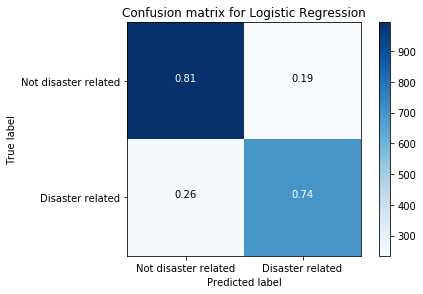

In [254]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_log)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Confusion matrix for Logistic Regression')

plt.show()

# Random Forest

In [130]:
pipe_forest = Pipeline(
        [('select', SelectFromModel(LogisticRegression(solver='liblinear', C=0.4, max_iter=500, random_state=0, class_weight='balanced'))),
        ('model', RandomForestClassifier(warm_start=True, n_estimators=250, random_state=0))])
param_grid = [{}] 
grid_search = GridSearchCV(pipe_forest, param_grid,cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=69).split(X_train, y_train), verbose=2)
model_forest = grid_search.fit(X_train, y_train)
y_preds_forest = model_forest.predict(X_test)
report_forest = classification_report( y_test, y_preds_forest )
print(report_forest)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=  17.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.5s remaining:    0.0s


[CV] ................................................. , total=  16.7s
[CV]  ................................................................
[CV] ................................................. , total=  18.2s
[CV]  ................................................................
[CV] ................................................. , total=  17.7s
[CV]  ................................................................
[CV] ................................................. , total=  15.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished


              precision    recall  f1-score   support

           0       0.75      0.89      0.82      1227
           1       0.82      0.62      0.70       945

   micro avg       0.77      0.77      0.77      2172
   macro avg       0.78      0.76      0.76      2172
weighted avg       0.78      0.77      0.77      2172



In [132]:
print(accuracy_score( y_test, y_preds_forest ))

0.7739410681399632


Confusion Matrix for Random Forest

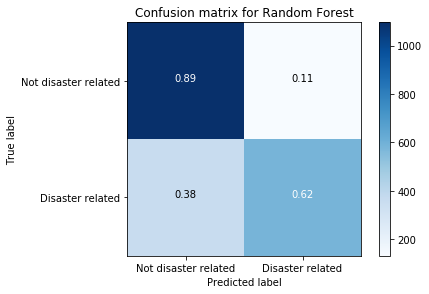

In [256]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_forest)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Confusion matrix for Random Forest')

plt.show()

# Linear SVC

In [169]:
pipe_svc = Pipeline(
        [('select', SelectFromModel(LogisticRegression(solver='liblinear',C=1.2, max_iter=5000, random_state=0,class_weight='balanced'))),
         ('model', LinearSVC(C=0.1, max_iter=15000, random_state=0, class_weight='balanced'))])
param_grid = [{}] 
grid_search = GridSearchCV(pipe_svc, param_grid,cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=69).split(X_train, y_train), verbose=2)
model_svc = grid_search.fit(X_train, y_train)
y_preds_svc = model_svc.predict(X_test)
report_svc = classification_report( y_test, y_preds_svc )
print(report_svc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   4.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] ................................................. , total=   5.3s
[CV]  ................................................................
[CV] ................................................. , total=   5.3s
[CV]  ................................................................
[CV] ................................................. , total=   5.3s
[CV]  ................................................................
[CV] ................................................. , total=   3.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.2s finished


              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1227
           1       0.74      0.72      0.73       945

   micro avg       0.77      0.77      0.77      2172
   macro avg       0.77      0.77      0.77      2172
weighted avg       0.77      0.77      0.77      2172



In [163]:
print(accuracy_score( y_test, y_preds_svc ))

0.7748618784530387


Confusion Matrix for Linear SVC

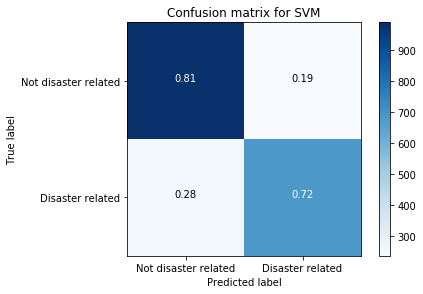

In [257]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_svc)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Confusion matrix for SVM')

plt.show()

# SGDClassifier

In [199]:
pipe_svm = Pipeline(
        [('select', SelectFromModel(LogisticRegression(solver='liblinear',max_iter=5000,class_weight='balanced',random_state=0, C=0.5))),
        ('model', SGDClassifier(loss='hinge', alpha=0.0006, random_state=0,tol=0.0001))])
param_grid = [{}] 
grid_search = GridSearchCV(pipe_svm, param_grid,cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=69).split(X_train, y_train), verbose=2)
model_svm = grid_search.fit(X_train, y_train)
y_preds_svm = model_svm.predict(X_test)
report_svm = classification_report(y_test, y_preds_svm)
print(report_svm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   4.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] ................................................. , total=   4.8s
[CV]  ................................................................
[CV] ................................................. , total=   4.4s
[CV]  ................................................................
[CV] ................................................. , total=   5.5s
[CV]  ................................................................
[CV] ................................................. , total=   4.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.8s finished


              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1227
           1       0.76      0.69      0.73       945

   micro avg       0.77      0.77      0.77      2172
   macro avg       0.77      0.76      0.77      2172
weighted avg       0.77      0.77      0.77      2172



In [201]:
print(accuracy_score( y_test, y_preds_svm ))

0.7739410681399632


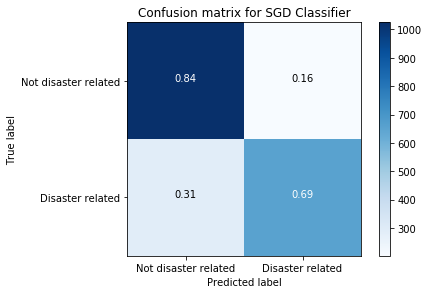

In [258]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_svm)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Confusion matrix for SGD Classifier')

plt.show()

# Naive Bayes

In [215]:
### Gaussian NB
pipe_gau = Pipeline(
        [('select', SelectFromModel(LogisticRegression(solver='liblinear',random_state=0,C=0.1, class_weight='balanced'))),
         ('model', GaussianNB())])
param_grid = [{}] 
grid_search = GridSearchCV(pipe_gau, param_grid,cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=69).split(X_train, y_train), verbose=2)
model_gau = grid_search.fit(X_train, y_train)
y_preds_gau = model_gau.predict(X_test)
report_gau = classification_report( y_test, y_preds_gau )
print(report_gau)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   3.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] ................................................. , total=   3.3s
[CV]  ................................................................
[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] ................................................. , total=   2.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.5s finished


              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1227
           1       0.77      0.62      0.69       945

   micro avg       0.76      0.76      0.76      2172
   macro avg       0.76      0.74      0.74      2172
weighted avg       0.76      0.76      0.75      2172



In [216]:
print(accuracy_score( y_test, y_preds_gau ))

0.7550644567219152


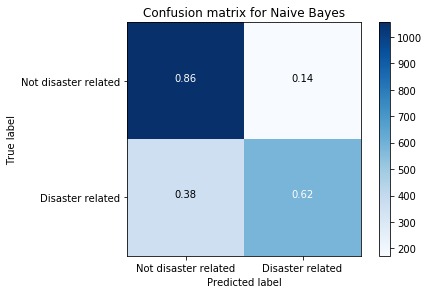

In [259]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_gau)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Confusion matrix for Naive Bayes')

plt.show()

# Extra Trees

In [230]:
pipe_ex = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',solver='liblinear',C=1.5))),
         ('model', ExtraTreesClassifier(n_estimators=500, random_state=0))])
param_grid = [{}] 
grid_search = GridSearchCV(pipe_ex, param_grid,cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=69).split(X_train, y_train), verbose=2)
model_ex = grid_search.fit(X_train, y_train)
y_preds_ex = model_ex.predict(X_test)
report_ex = classification_report( y_test, y_preds_ex )
print(report_ex)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=  32.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.5s remaining:    0.0s


[CV] ................................................. , total=  33.4s
[CV]  ................................................................
[CV] ................................................. , total=  31.3s
[CV]  ................................................................
[CV] ................................................. , total=  29.1s
[CV]  ................................................................
[CV] ................................................. , total=  28.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1227
           1       0.85      0.63      0.73       945

   micro avg       0.79      0.79      0.79      2172
   macro avg       0.81      0.77      0.78      2172
weighted avg       0.80      0.79      0.79      2172



In [231]:
print(accuracy_score( y_test, y_preds_ex ))

0.7914364640883977


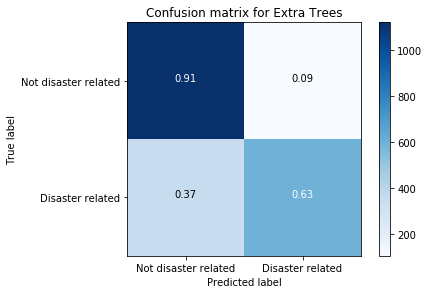

In [260]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_ex)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Confusion matrix for Extra Trees')

plt.show()

# Neural Network

In [253]:
pipe_neural = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',solver='liblinear',C=0.01, random_state=0))),
         ('model', MLPClassifier(activation='identity',max_iter=1000, learning_rate='adaptive'))])
param_grid = [{}] 
grid_search = GridSearchCV(pipe_neural, param_grid,cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=69).split(X_train, y_train), verbose=2)
model_neural = grid_search.fit(X_train, y_train)
y_preds_neural = model_neural.predict(X_test)
report_neural = classification_report( y_test, y_preds_neural )
print(report_neural)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   6.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] ................................................. , total=   5.1s
[CV]  ................................................................
[CV] ................................................. , total=  10.5s
[CV]  ................................................................
[CV] ................................................. , total=   9.0s
[CV]  ................................................................
[CV] ................................................. , total=   8.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.6s finished


              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1227
           1       0.74      0.73      0.74       945

   micro avg       0.77      0.77      0.77      2172
   macro avg       0.77      0.77      0.77      2172
weighted avg       0.77      0.77      0.77      2172



In [251]:
print(accuracy_score( y_test, y_preds_neural ))

0.7656537753222836


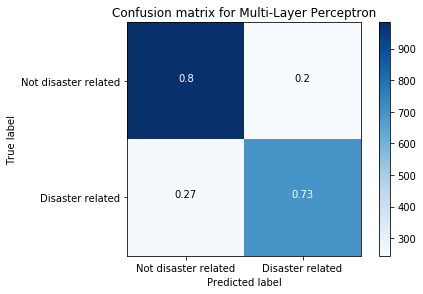

In [261]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_neural)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, title='Confusion matrix for Multi-Layer Perceptron')

plt.show()